In [2]:
import requests
from datetime import datetime, timedelta
import pandas as pd
import re
import itertools
import matplotlib.pyplot as plt
from collections import Counter
import numpy as np

# Данные для запроса
access_token = "vk1.a.nuXxpclU0Gc3koMcFE1cnRztIKJD7nUvR-B5JboHTwV_XdoOIm99795ubTdhwsO29bqiKG6DtrjiWH3sc4FgEBNtn8XeBHUprMLmwKyONAjbEvM3OeXxhgB-GE9SkffucUekrj7iy5wSrSPWgo1ZN3d-1n1_Xmiw05IqvSTxVBP4sifkPHz5PTTNfsiHop1iTcW8auAXkKOZvsSiSrsSIg"
url_start = "https://vk.com/kinocube_official"
url = url_start.split('/')
domain = url[-1]

# Получаем id группы через запрос
def get_group_id(access_token, domain):
    response = requests.get('https://api.vk.com/method/utils.resolveScreenName',
                            params={'access_token': access_token,
                                    'screen_name': domain,
                                    'v': 5.199})
    response_json = response.json()
    if 'response' in response_json and 'object_id' in response_json['response']:
        return response_json['response']['object_id']
    else:
        raise ValueError("Не удалось получить ID группы. Проверьте корректность access_token и domain.")

# Получаем ID группы
id_group = get_group_id(access_token, domain)

# Функция для получения данных по запросу
def getjson(url):
    response = requests.get(url)
    response = response.json()
    return response

# Пример использования функции getjson
def fetch_vk_data(access_token, id_group):
    version = '5.199'
    url = f"https://api.vk.com/method/wall.get?access_token={access_token}&owner_id=-{id_group}&count=100&v={version}"
    data = getjson(url)
    return data

# Пример вызова
try:
    vk_data = fetch_vk_data(access_token, id_group)
    print(vk_data)
except Exception as e:
    print(f"Произошла ошибка: {e}")

{'response': {'count': 319, 'items': [{'inner_type': 'wall_wallpost', 'ads_easy_promote': {'type': 0, 'text': ' В записи не должно быть эмодзи.', 'label_text': '', 'button_text': '', 'is_ad_not_easy': False}, 'can_delete': 1, 'can_pin': 1, 'donut': {'is_donut': False}, 'is_pinned': 1, 'comments': {'can_post': 1, 'can_close': 1, 'can_view': 1, 'count': 0, 'groups_can_post': True}, 'marked_as_ads': 0, 'hash': 'Bjk8--e2s1w9gq3kBJRfw-OqoQyV', 'postponed_id': 961, 'type': 'post', 'attachments': [{'type': 'video', 'video': {'response_type': 'full', 'access_key': '92ab0374f9385007f5', 'can_comment': 1, 'can_edit': 1, 'can_delete': 1, 'can_like': 1, 'can_repost': 1, 'can_add_to_faves': 1, 'can_add': 1, 'can_attach_link': 1, 'can_edit_privacy': 1, 'comments': 0, 'date': 1728318341, 'description': 'by КиноКуб, встреча 13.10.2024\n\nВ видео использована песня: Brandon Lau – Collapsing Sun. https://vk.com/audio-48978513_456241510_63477ff72ca6ed5aba', 'duration': 78, 'image': [{'url': 'https://sun9

In [6]:
# Создание переменной для "сдвига" получаемых данных
offset = 0
# Количество строк данных для одного запроса
count = 1
# Список ответов сервера
responses = []
days = 0
while days  < 365:
    url = 'https://api.vk.com/method/wall.get?access_token='+ access_token + '&offset='+ str(offset) + '&count=' + str(count) + '&v=' + '5.199' + '&domain=' + 'kinocube_official'
    response = getjson(url)
    responses.append(response)
    days = (datetime.now() - datetime.fromtimestamp(response['response']['items'][0]['date'])).days
    offset+=1

In [7]:
# Создаем списки содержащие в себе определенный набор данных

likes = []
views = []
comments = []
date = []
text = []
reposts = []
hash_tags = []
post_id = []
votes = []
attachments = []

expr = r'#\w+'

for j in range(len(responses)):
    for i in range(count):
        # Общую часть запроса к json словарю определим переменной
        main_dict = responses[j]['response']['items'][i]
        # Список id постов
        post_id.append(main_dict['id'])
        # Список количества репостов
        reposts.append(main_dict['reposts']['count'])
        # Список текстов постов
        text.append(len(main_dict['text']))
        # Список количества лайков
        likes.append(main_dict['likes']['count'])
        # Список количества просмотров постов
        views.append(main_dict['views']['count'])
        # Список количества комментариев
        comments.append(main_dict['comments']['count'])
        # Находим хэштеги
        tags = re.findall(expr, main_dict['text'])
        # Список преобразованных хэштегов
        hash_tags.append(list(map(lambda x: x[1:].lower().replace('_', ' ').replace('skillbox', '').strip(),tags)))
        # Список преобразованных дат
        date.append((datetime.fromtimestamp(main_dict['date']) - timedelta(hours=0)))
        # Список типов медиавложений в посте
        attachments.append(list(set([list(x.keys())[1] for x in main_dict['attachments']])))
        # Список голосов в постах с прикрепленным голосованием
        try:
            votes.append(main_dict['attachments'][1]['poll']['votes'])
        except:
            votes.append(None)

# Создаем пустой датафрейм
data = pd.DataFrame()

# Наполняем датафрейм полученными списками
data['id'] = post_id
data['likes'] = likes
data['views'] = views
data['reposts'] = reposts
data['comments'] = comments
data['date'] = date
data['text'] = text
data['tags'] = hash_tags
data['votes'] = votes
data['attachments'] = attachments

data

,id,likes,views,reposts,comments,date,text,tags,votes,attachments
0,962,18,718,4,0,2024-10-07 21:00:00,592,[анонс],None,[video]
1,984,9,149,3,0,2024-10-15 23:30:00,903,[анонс],None,[photo]
2,982,14,430,4,0,2024-10-13 00:00:02,2126,[авторское],None,[photo]
3,980,10,268,0,0,2024-10-12 18:31:39,359,[авторское],None,[video]
4,975,16,442,1,2,2024-10-11 22:00:00,2045,[авторское],None,[photo]
...,...,...,...,...,...,...,...,...,...,...
196,498,23,791,3,0,2023-10-20 21:00:01,2893,[авторское],None,[photo]
197,495,20,864,0,2,2023-10-19 14:00:01,278,[новости],None,[photo]
198,493,22,861,3,0,2023-10-18 15:00:01,3637,[авторское],None,[photo]
199,491,30,832,3,1,2023-10-17 23:00:00,2994,[авторское],None,[photo]


In [8]:
# Выгружаем данные в файл CSV
data.to_csv('vk_data.csv', index=False, encoding='utf-8-sig')

In [9]:
# Посмотрим какие существуют хэштеги в нашем паблике

new_list=set()
for i in data.tags:
    for j in i:
        new_list.add(j)

new_list

{'o личности',
 'trainspotting',
 'авторское',
 'анонс',
 'деньмолодежи',
 'деньрождения',
 'деньстудента',
 'достучатьсядонебес',
 'драйв',
 'дюна2',
 'железныйчеловек',
 'идеальныедни',
 'калигари',
 'кинофестиваль',
 'кинфестиваль',
 'майклбэй',
 'маленькиеженщины',
 'мартинскорсезе',
 'мюзиклыотмарфы',
 'наигле',
 'новости',
 'новыйгод',
 'носферату',
 'о личности',
 'оличности',
 'отчаянныедомохозяйки',
 'отчёт',
 'почемустоитпосмотреть',
 'разведка',
 'ребенокрозмари',
 'скоттпилигримпротиввсех',
 'твинпикс',
 'технокино',
 'хеллоуин',
 'хиросимамоялюбовь',
 'чарли и шоколадная фабрика',
 'человексбульваракапуцинов',
 'чудеснаяисториягенришугара'}

In [10]:
# Функция для подсчета количества встречающихся хэштегов

def counter(x, array):
    value = 0
    for item_list in array:
        if x in item_list:
            value += 1
    return value

In [25]:
# Датафрейм со значением хэштэга и его количеством

counts_df = pd.DataFrame()

new_list = list(new_list)

counts = list(map(lambda x: counter(x, list(data.tags)), new_list))
counts_df['value'] = new_list
counts_df['count'] = counts
counts_df.sort_values('count', ascending=False).head(25)

,value,count
18,авторское,125
27,кинофестиваль,26
2,анонс,24
5,новости,10
36,отчёт,7
20,о личности,6
37,технокино,3
22,твинпикс,2
15,новыйгод,2
3,оличности,2


In [28]:
# Распределяем хэштеги по подходяшим рубрикам

dict_of_rubr = {
    'Статья':['статья', 'авторское'],
    'Вам слово':['вам слово'],
    'Отчет':['отчёт', 'podcast', 'подкасты'],
    'Анонс':['анонс',],
    'Новости':['новости',],
    'Фестиваль':['кинофестиваль', 'технокино'],
    'Оличности':['оличности', 'о личности'],
}

In [29]:
# Преобразуем словарь с рубриками к удобному для работы виду

lists_of_rubr =[[(i, j) for j in dict_of_rubr[i]] for i in dict_of_rubr]

flatten_genres = list(itertools.chain(*lists_of_rubr))

rubr_df = pd.DataFrame(flatten_genres, columns = ['genre', 'word'])

In [30]:
# Функция для подбора рубрики для постов

def equality(x, df):
    list_new = []
    for i in x:
        for j in i:
            if j in list(df.word):
                list_new.append(df.set_index('word').loc[j,:].values[0])
                break                    
        else:
            list_new.append('Без рубрики')
    return list_new

In [31]:
# Применяем функию по подбору рубрик к нашему батафрейму
data['rubr'] = equality(data.tags, rubr_df)
# Создаем новый датафрейм со средними значениями данных по метрикам активности пользователей для каждой рубрики
data_avg = data[['rubr', 'likes', 'views', 'reposts', 'comments', 'votes']]\
    .groupby('rubr')\
    .agg('mean')
data_avg

,likes,views,reposts,comments,votes
rubr,,,,,
Анонс,26.041667,1251.958333,10.833333,0.666667,NaN
Без рубрики,17.625000,831.062500,3.000000,0.750000,NaN
Новости,28.100000,827.000000,4.100000,1.400000,NaN
Оличности,17.000000,663.000000,2.000000,2.000000,NaN
Отчет,20.142857,672.142857,1.142857,0.857143,NaN
Статья,20.903226,671.564516,1.669355,0.435484,NaN
Фестиваль,20.157895,637.894737,1.736842,0.315789,NaN


In [32]:
# Удельные показатели активности пользователей. Каждая метрика в завсисмости от количества просмотров в процентах

data_spec = data_avg[['likes','comments','reposts']].div(data_avg['views'], axis=0)*1000
data_spec

,likes,comments,reposts
rubr,,,
Анонс,20.800745,0.532499,8.653110
Без рубрики,21.207791,0.902459,3.609837
Новости,33.978235,1.692866,4.957678
Оличности,25.641026,3.016591,3.016591
Отчет,29.968119,1.275239,1.700319
Статья,31.126162,0.648462,2.485770
Фестиваль,31.600660,0.495050,2.722772


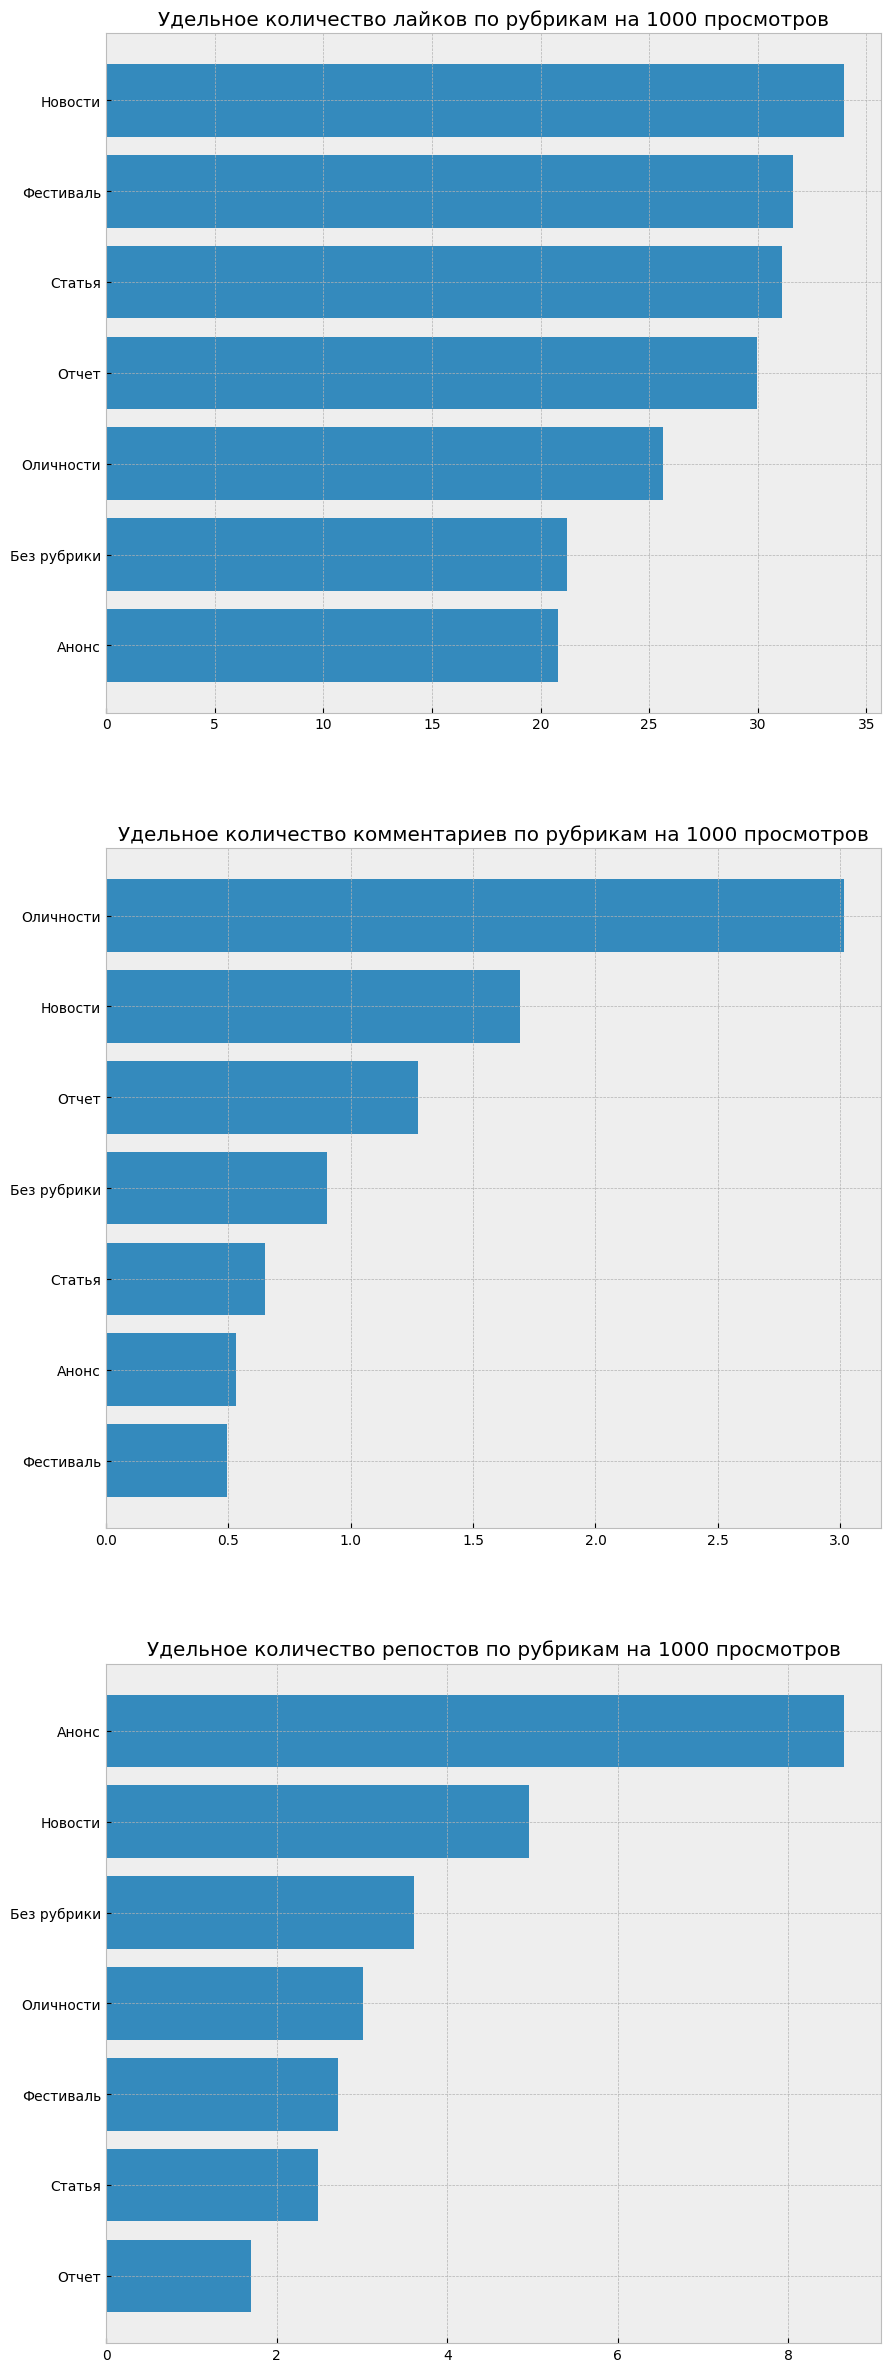

In [34]:
# Построим графики удельного количества лайков, комментариев и репостов для всех рубрик
plt.style.use('bmh')
fig = plt.figure(figsize=(10,30))
ax = fig.add_subplot(3,1,1)
ax.barh(data_spec.sort_values('likes',ascending=True).index, data_spec.sort_values('likes',ascending=True).likes)
ax.set_title('Удельное количество лайков по рубрикам на 1000 просмотров')
ax = fig.add_subplot(3,1,2)
ax.barh(data_spec.sort_values('comments',ascending=True).index, data_spec.sort_values('comments',ascending=True).comments)
ax.set_title('Удельное количество комментариев по рубрикам на 1000 просмотров')
ax = fig.add_subplot(3,1,3)
ax.barh(data_spec.sort_values('reposts',ascending=True).index, data_spec.sort_values('reposts',ascending=True).reposts)
ax.set_title('Удельное количество репостов по рубрикам на 1000 просмотров')
plt.show()

In [36]:
# Список дней недели
weekdays = ['Понедельник', 'Вторник', 'Среда', 'Четверг', 'Пятница', 'Суббота', 'Воскресенье']
# Замена индексов дней недели на название
data['day_of_week'] = list(map(lambda x: weekdays[x.weekday()], data.date))

In [37]:
# Средние значения метрик активности в каждом посте в течение недели
data_days = data[['likes', 'views', 'reposts', 'comments', 'votes', 'day_of_week']]\
    .groupby('day_of_week')\
    .agg('mean')\
    .reindex(weekdays)
data_days

,likes,views,reposts,comments,votes
day_of_week,,,,,
Понедельник,20.695652,729.434783,4.869565,0.826087,NaN
Вторник,21.969697,711.969697,2.515152,0.696970,NaN
Среда,20.437500,904.281250,2.875000,0.250000,NaN
Четверг,20.322581,677.903226,2.032258,0.387097,NaN
Пятница,23.606061,791.636364,3.121212,0.575758,NaN
Суббота,21.870968,682.225806,2.483871,0.741935,NaN
Воскресенье,21.055556,826.611111,3.833333,0.333333,NaN


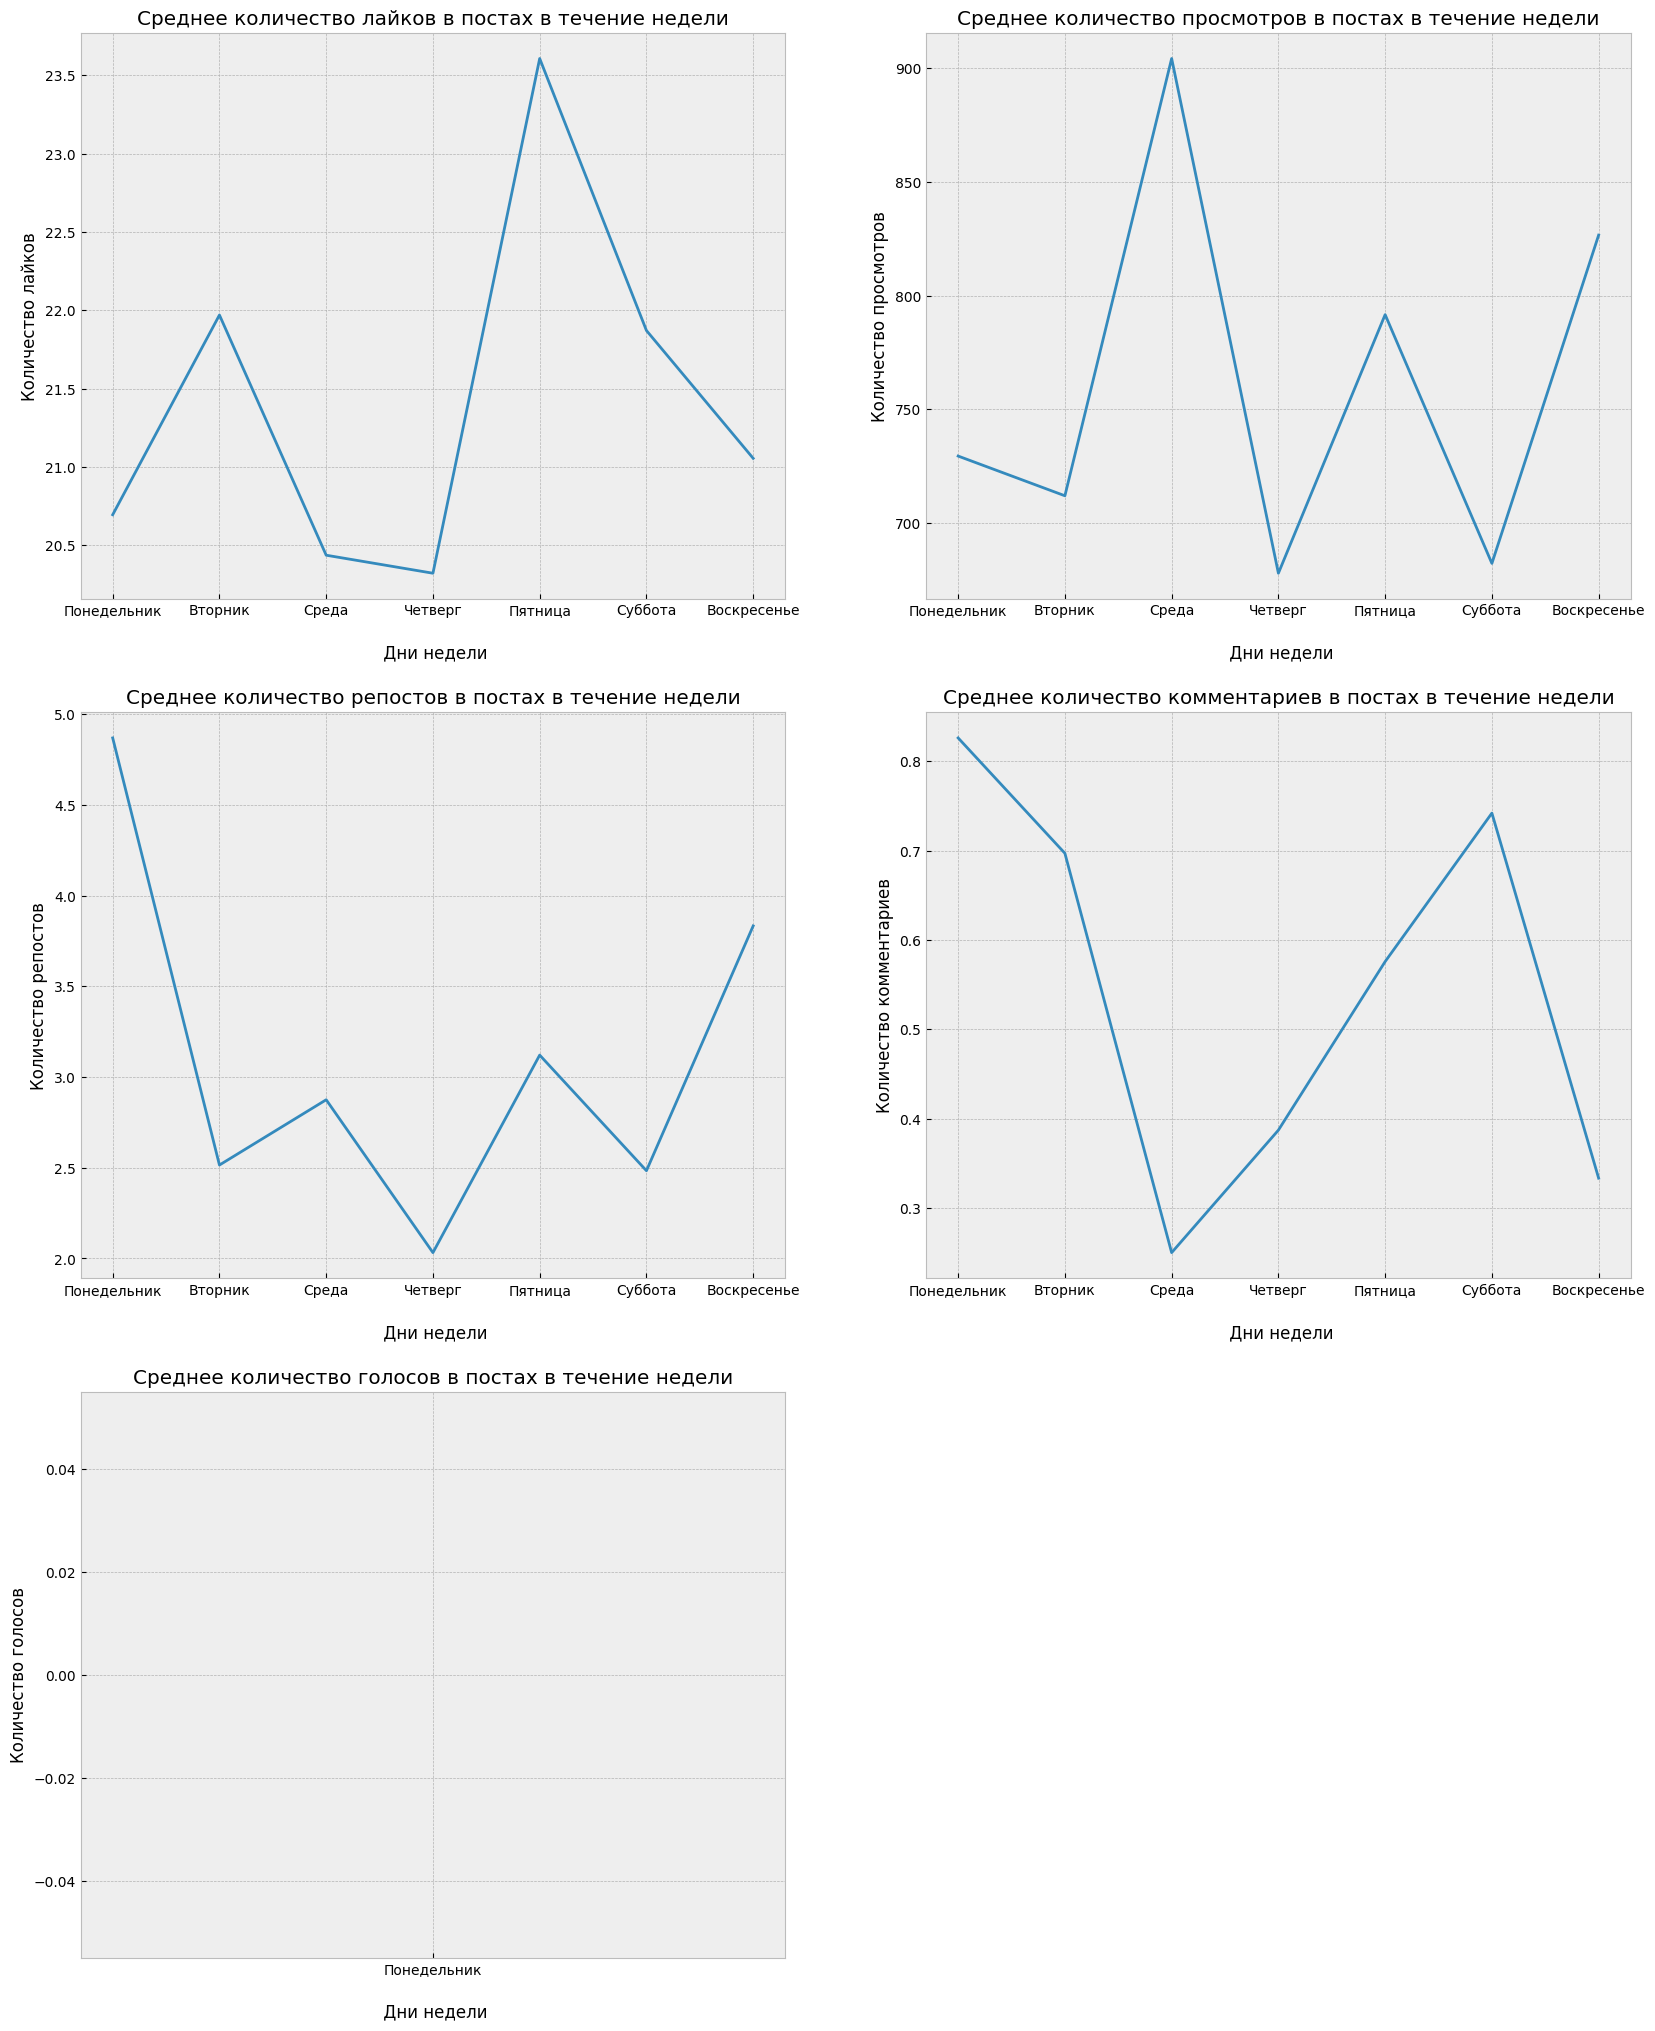

In [38]:
fig = plt.figure(figsize=(20,25))
ax = fig.add_subplot(3,2,1)
ax.plot(data_days.index, data_days.likes)
ax.set_xlabel('\n Дни недели')
ax.set_ylabel('Количество лайков')
plt.title('Среднее количество лайков в постах в течение недели')
ax = fig.add_subplot(3,2,2)
ax.plot(data_days.index, data_days.views)
ax.set_xlabel('\n Дни недели')
ax.set_ylabel('Количество просмотров')
plt.title('Среднее количество просмотров в постах в течение недели')
ax = fig.add_subplot(3,2,3)
ax.plot(data_days.index, data_days.reposts)
ax.set_xlabel('\n Дни недели')
ax.set_ylabel('Количество репостов')
plt.title('Среднее количество репостов в постах в течение недели')
ax = fig.add_subplot(3,2,4)
ax.plot(data_days.index, data_days.comments)
ax.set_xlabel('\n Дни недели')
ax.set_ylabel('Количество комментариев')
plt.title('Среднее количество комментариев в постах в течение недели')
ax = fig.add_subplot(3,2,5)
ax.plot(data_days.index, data_days.votes)
ax.set_xlabel('\n Дни недели')
ax.set_ylabel('Количество голосов')
plt.title('Среднее количество голосов в постах в течение недели')
plt.show()

In [39]:
# Удельные показатели активности пользователей. Средняя доля каждой метрики на один просмотр поста

data_days_spec = data_days.div(data_days['views'], axis=0)*100
del data_days_spec['views']
data_days_spec.reindex(weekdays)

,likes,reposts,comments,votes
day_of_week,,,,
Понедельник,2.837218,0.667581,0.113250,NaN
Вторник,3.085763,0.353267,0.097893,NaN
Среда,2.260082,0.317932,0.027646,NaN
Четверг,2.997859,0.299786,0.057102,NaN
Пятница,2.981932,0.394273,0.072730,NaN
Суббота,3.205825,0.364083,0.108752,NaN
Воскресенье,2.547214,0.463741,0.040325,NaN


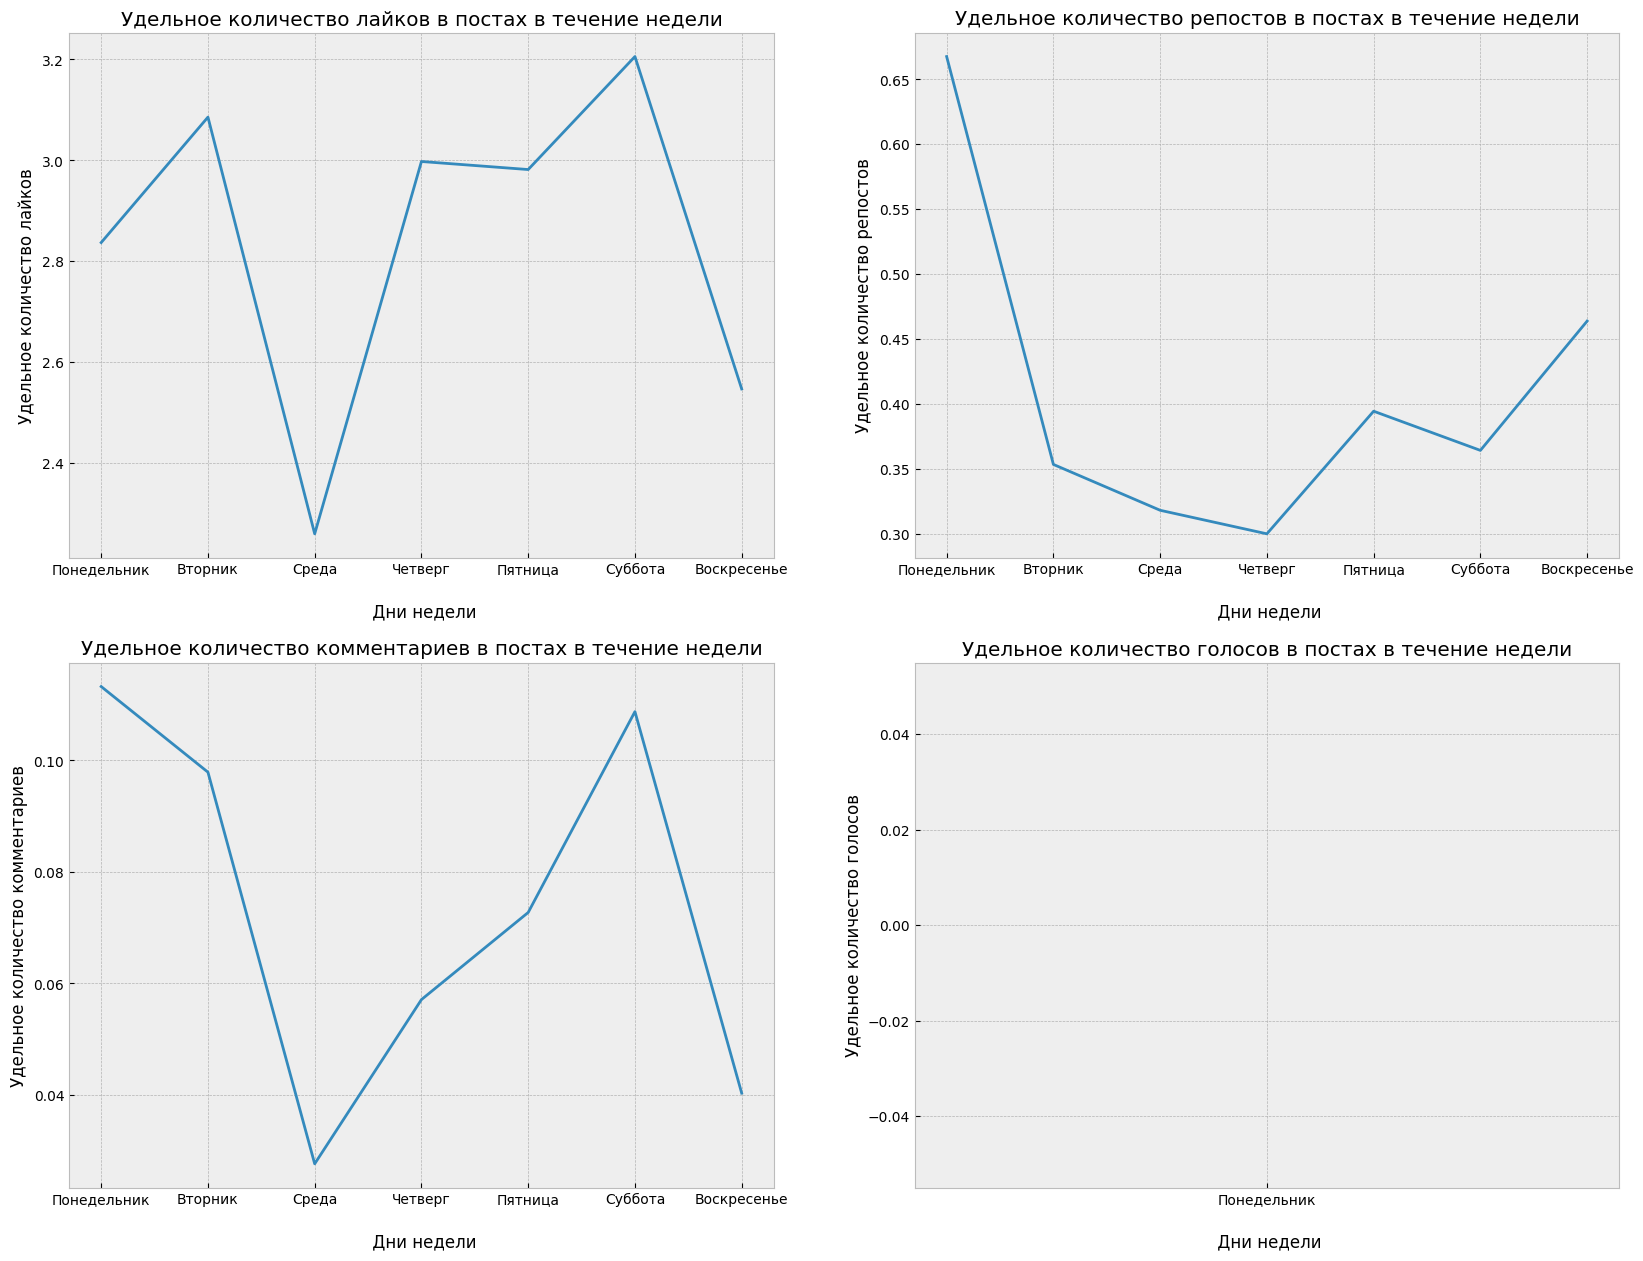

In [40]:
fig = plt.figure(figsize=(20,15))
ax = fig.add_subplot(2,2,1)
ax.plot(data_days_spec.index, data_days_spec.likes)
ax.set_xlabel('\n Дни недели')
ax.set_ylabel('Удельное количество лайков')
plt.title('Удельное количество лайков в постах в течение недели')
ax = fig.add_subplot(2,2,2)
ax.plot(data_days_spec.index, data_days_spec.reposts)
ax.set_xlabel('\n Дни недели')
ax.set_ylabel('Удельное количество репостов')
plt.title('Удельное количество репостов в постах в течение недели')
ax = fig.add_subplot(2,2,3)
ax.plot(data_days_spec.index, data_days_spec.comments)
ax.set_xlabel('\n Дни недели')
ax.set_ylabel('Удельное количество комментариев')
plt.title('Удельное количество комментариев в постах в течение недели')
ax = fig.add_subplot(2,2,4)
ax.plot(data_days_spec.index, data_days_spec.votes)
ax.set_xlabel('\n Дни недели')
ax.set_ylabel('Удельное количество голосов')
plt.title('Удельное количество голосов в постах в течение недели')
plt.show()

In [41]:
# Добавляем в датасет столбец со значениями часов в момент публикаций постов

data['hour_post'] = list(map(lambda x: x.hour, data.date))

In [43]:
# Создадим датасет с будними днями
data_weekdays = data[(data['day_of_week'] == "Понедельник") |
                     (data['day_of_week'] == "Вторник") |
                     (data['day_of_week'] == "Среда") |
                     (data['day_of_week'] == "Четверг") |
                     (data['day_of_week'] == "Пятница")]


data_hours = data_weekdays[['likes', 'views', 'reposts', 'comments', 'votes', 'hour_post']]\
    .groupby('hour_post')\
    .mean()

# Удельные показатели активности пользователей. Каждая метрика в завсисмости от каждой 1000 просмотров данной публикации

data_weekdays_spec = data_hours[['likes','comments','reposts']].div(data_hours.views, axis=0)*1000
data_weekdays_spec['views'] = data_hours['views']
data_weekdays_spec

,likes,comments,reposts,views
hour_post,,,,
0,30.188679,0.000000,0.000000,530.000000
9,56.129985,0.000000,2.954210,677.000000
10,19.524618,0.000000,3.395586,589.000000
11,35.447761,0.000000,1.865672,536.000000
12,29.861751,0.184332,6.820276,775.000000
13,30.413803,0.584881,2.485744,759.888889
14,27.978142,1.748634,3.060109,915.000000
15,24.433371,0.321492,2.732680,777.625000
16,31.460674,1.021450,5.107252,699.285714


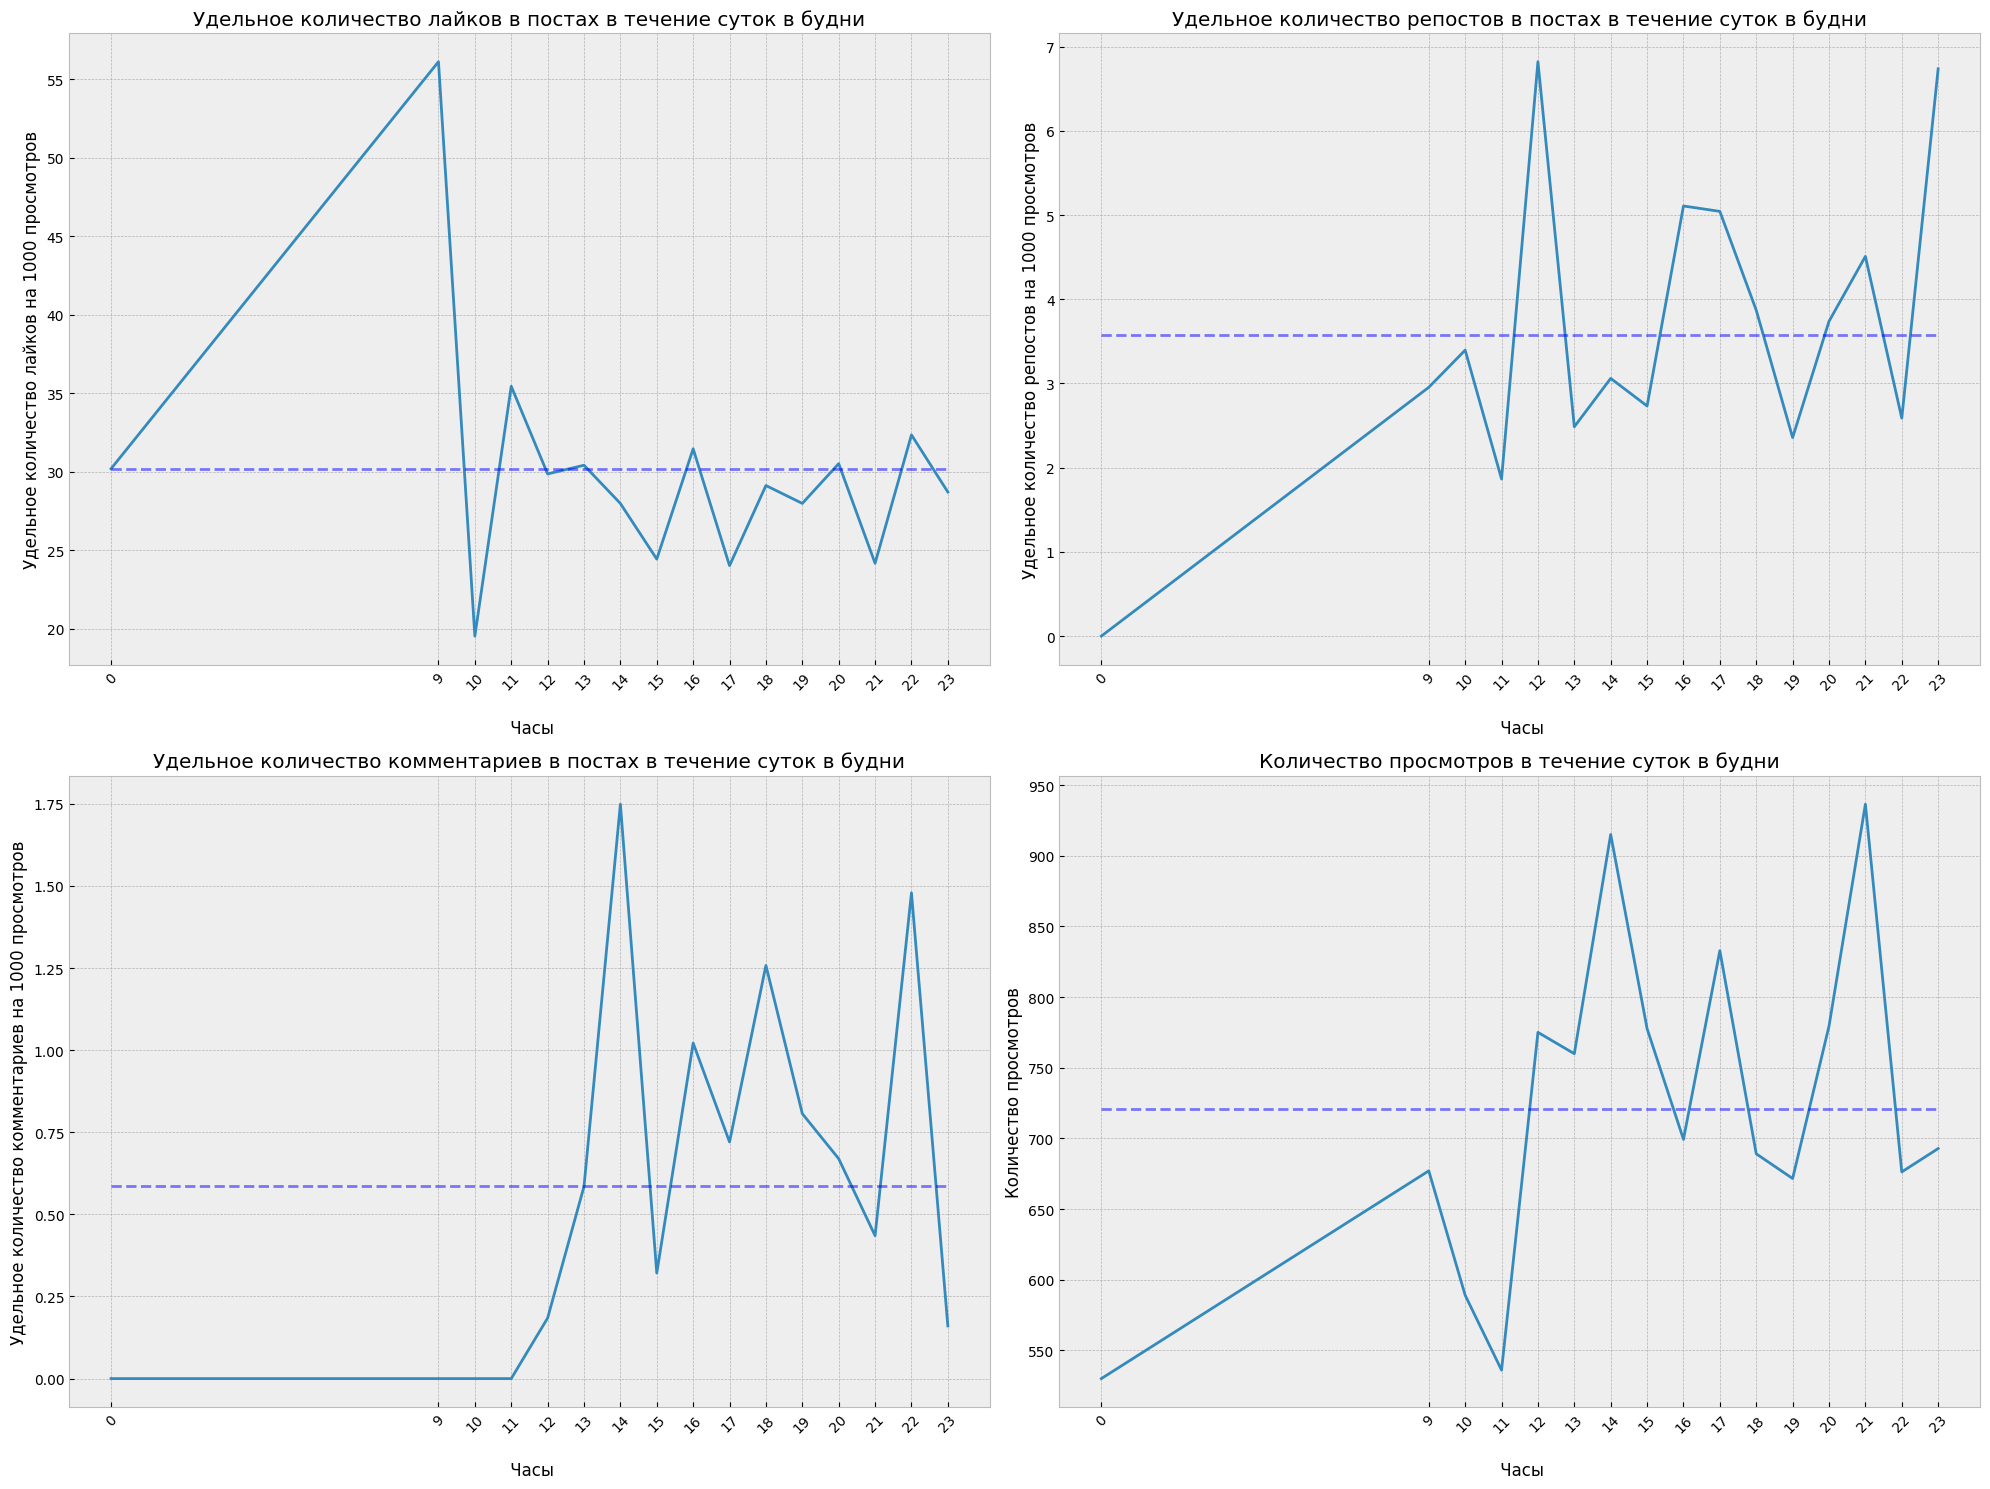

In [47]:
# Построим графики распределения удельных значений активностей пользователей в течение суток в будние дни

fig = plt.figure(figsize=(20,15))
# График 1: Удельное количество лайков на 1000 просмотров
ax = fig.add_subplot(2, 2, 1)
ax.plot(data_weekdays_spec.index, data_weekdays_spec.likes)
ax.set_xlabel('\n Часы')
ax.set_ylabel('Удельное количество лайков на 1000 просмотров')
plt.title('Удельное количество лайков в постах в течение суток в будни')
plt.hlines(data_weekdays_spec.likes.mean(), data_weekdays_spec.index.min(), data_weekdays_spec.index.max(), colors='blue', linestyles='--', alpha=0.5)
ax.set_xticks(data_weekdays_spec.index)  # Устанавливаем шаг 1 для отображения каждого часа
ax.set_xticklabels(data_weekdays_spec.index, rotation=45)  # Поворачиваем метки для лучшей читаемости

# График 2: Удельное количество репостов на 1000 просмотров
ax = fig.add_subplot(2, 2, 2)
ax.plot(data_weekdays_spec.index, data_weekdays_spec.reposts)
ax.set_xlabel('\n Часы')
ax.set_ylabel('Удельное количество репостов на 1000 просмотров')
plt.title('Удельное количество репостов в постах в течение суток в будни')
plt.hlines(data_weekdays_spec.reposts.mean(), data_weekdays_spec.index.min(), data_weekdays_spec.index.max(), colors='blue', linestyles='--', alpha=0.5)
ax.set_xticks(data_weekdays_spec.index)  # Устанавливаем шаг 1 для отображения каждого часа
ax.set_xticklabels(data_weekdays_spec.index, rotation=45)  # Поворачиваем метки для лучшей читаемости

# График 3: Удельное количество комментариев на 1000 просмотров
ax = fig.add_subplot(2, 2, 3)
ax.plot(data_weekdays_spec.index, data_weekdays_spec.comments)
ax.set_xlabel('\n Часы')
ax.set_ylabel('Удельное количество комментариев на 1000 просмотров')
plt.title('Удельное количество комментариев в постах в течение суток в будни')
plt.hlines(data_weekdays_spec.comments.mean(), data_weekdays_spec.index.min(), data_weekdays_spec.index.max(), colors='blue', linestyles='--', alpha=0.5)
ax.set_xticks(data_weekdays_spec.index)  # Устанавливаем шаг 1 для отображения каждого часа
ax.set_xticklabels(data_weekdays_spec.index, rotation=45)  # Поворачиваем метки для лучшей читаемости

# График 4: Количество просмотров
ax = fig.add_subplot(2, 2, 4)
ax.plot(data_weekdays_spec.index, data_weekdays_spec.views)
ax.set_xlabel('\n Часы')
ax.set_ylabel('Количество просмотров')
plt.title('Количество просмотров в течение суток в будни')
plt.hlines(data_weekdays_spec.views.mean(), data_weekdays_spec.index.min(), data_weekdays_spec.index.max(), colors='blue', linestyles='--', alpha=0.5)
ax.set_xticks(data_weekdays_spec.index)  # Устанавливаем шаг 1 для отображения каждого часа
ax.set_xticklabels(data_weekdays_spec.index, rotation=45)  # Поворачиваем метки для лучшей читаемости

plt.tight_layout()  # Убираем лишние пробелы между подграфиками
plt.show()

In [48]:
data_weekend = data[(data['day_of_week'] == "Суббота") | (data['day_of_week'] == "Воскресенье")]

data_hours = data_weekend[['likes', 'views', 'reposts', 'comments', 'votes', 'hour_post']]\
    .groupby('hour_post')\
    .mean()

data_weekend_spec = data_hours[['likes','comments','reposts']].div(data_hours.views, axis=0)*1000
data_weekend_spec['views'] = data_hours['views']
data_weekend_spec

,likes,comments,reposts,views
hour_post,,,,
0,19.459459,0.000000,4.324324,462.500000
9,28.996283,0.000000,1.486989,672.500000
11,33.003300,0.000000,9.900990,909.000000
12,31.151420,1.971609,11.041009,1268.000000
13,27.822365,0.000000,0.000000,623.000000
14,33.798283,0.000000,1.609442,621.333333
16,14.660494,0.000000,1.543210,1296.000000
17,35.971223,0.685166,3.768414,729.750000
18,24.728741,0.252334,3.028009,566.142857


In [49]:
data_weekend_spec.index.min()

np.int64(0)

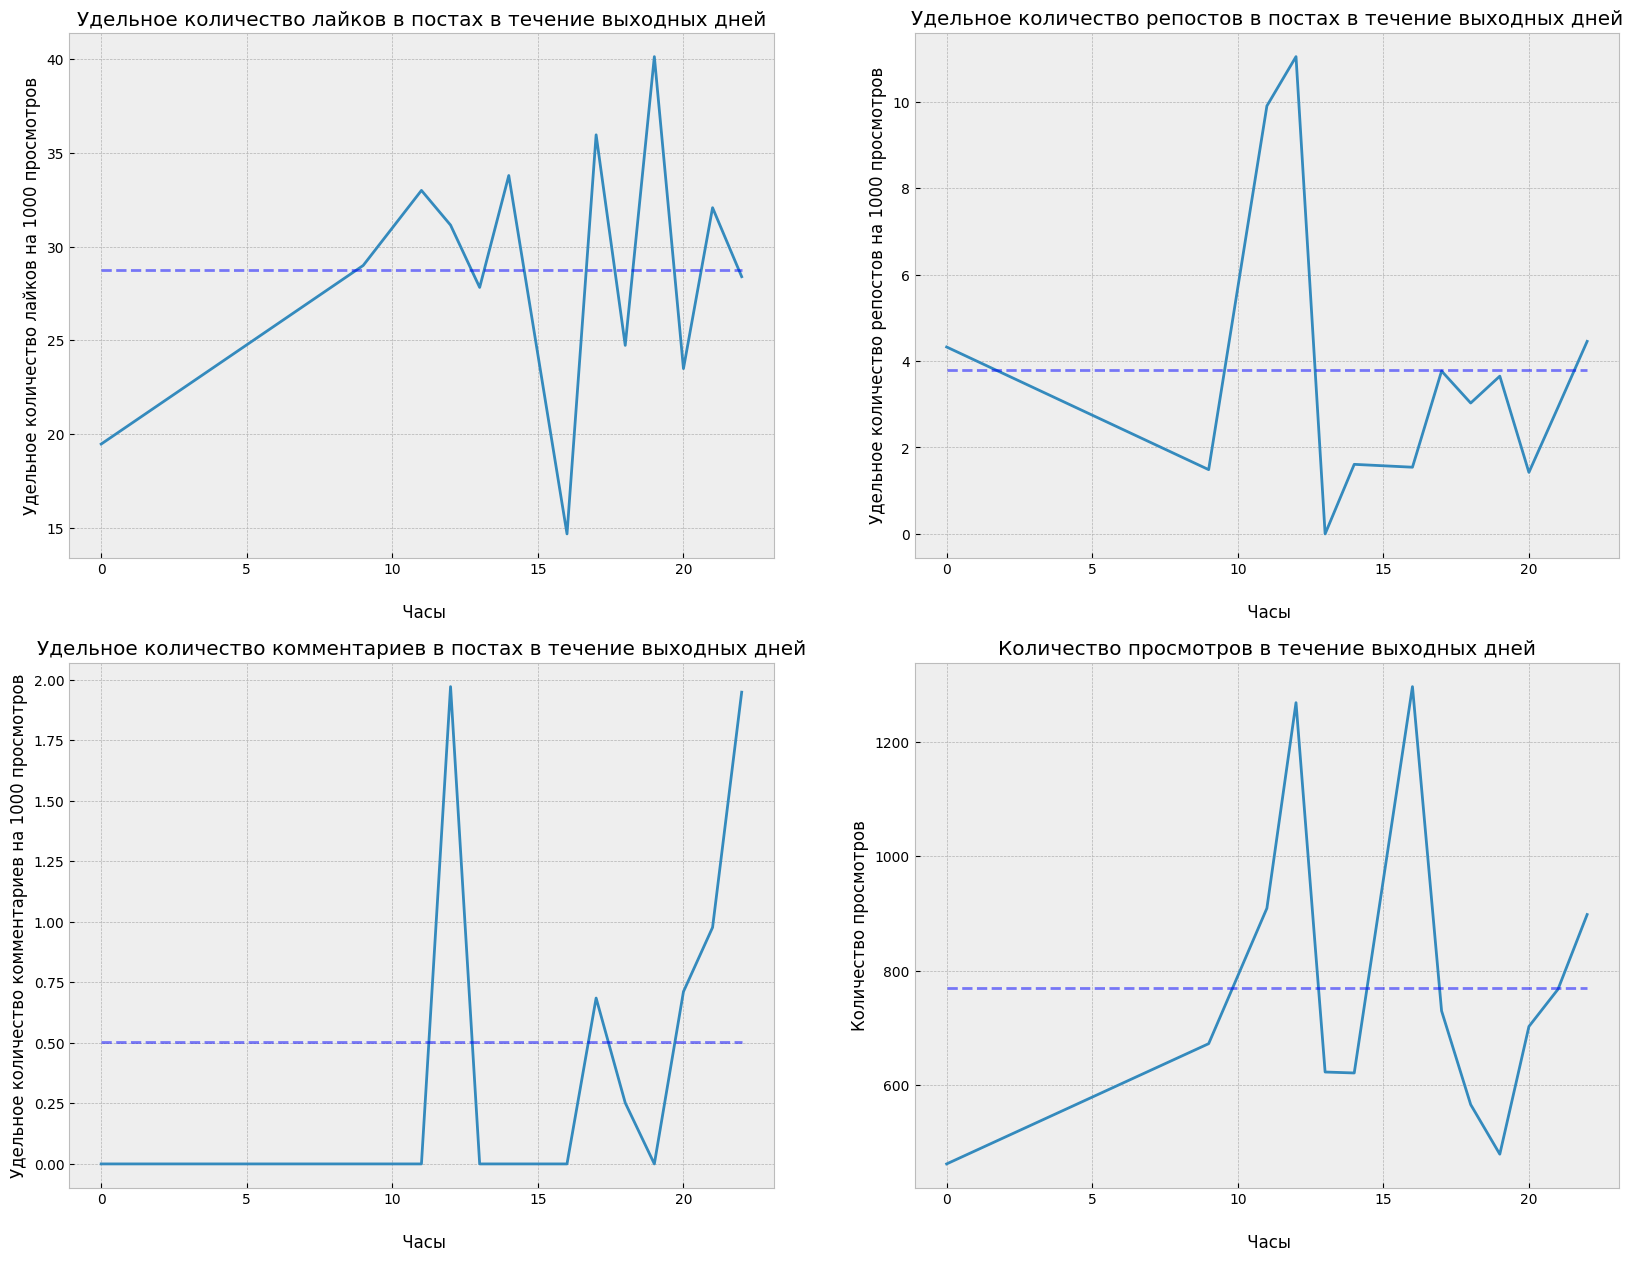

In [50]:
# Построим графики распределения удельных значений активностей пользователей в течение суток в выходные дни

fig = plt.figure(figsize=(20,15))
ax = fig.add_subplot(2,2,1)
ax.plot(data_weekend_spec.index, data_weekend_spec.likes)
ax.set_xlabel('\n Часы')
ax.set_ylabel('Удельное количество лайков на 1000 просмотров')
plt.title('Удельное количество лайков в постах в течение выходных дней')
plt.hlines(data_weekend_spec.likes.mean(), data_weekend_spec.index.min(),data_weekend_spec.index.max(), colors='blue', linestyles='--', alpha=0.5)
ax = fig.add_subplot(2,2,2)
ax.plot(data_weekend_spec.index, data_weekend_spec.reposts)
ax.set_xlabel('\n Часы')
ax.set_ylabel('Удельное количество репостов на 1000 просмотров')
plt.title('Удельное количество репостов в постах в течение выходных дней')
plt.hlines(data_weekend_spec.reposts.mean(), data_weekend_spec.index.min(),data_weekend_spec.index.max(), colors='blue', linestyles='--', alpha=0.5)
ax = fig.add_subplot(2,2,3)
ax.plot(data_weekend_spec.index, data_weekend_spec.comments)
ax.set_xlabel('\n Часы')
ax.set_ylabel('Удельное количество комментариев на 1000 просмотров')
plt.title('Удельное количество комментариев в постах в течение выходных дней')
plt.hlines(data_weekend_spec.comments.mean(), data_weekend_spec.index.min(),data_weekend_spec.index.max(), colors='blue', linestyles='--', alpha=0.5)
ax = fig.add_subplot(2,2,4)
ax.plot(data_weekend_spec.index, data_weekend_spec.views)
ax.set_xlabel('\n Часы')
ax.set_ylabel('Количество просмотров')
plt.title('Количество просмотров в течение выходных дней')
plt.hlines(data_weekend_spec.views.mean(), data_weekend_spec.index.min(),data_weekend_spec.index.max(), colors='blue', linestyles='--', alpha=0.5)
plt.show()

***Аналитика контента***

In [51]:
# Типы медиавложений и их сочетания в публикациях

set(' '.join(i) for i in data.attachments)

{'',
 'album link',
 'audio photo',
 'doc',
 'doc photo',
 'link',
 'link doc photo',
 'link photo',
 'photo',
 'photo poll',
 'video',
 'video link',
 'video photo'}

In [52]:
# Преоразование записей в удобный вид

data['attachments_new'] = list(map(lambda x: ' '.join(x), data.attachments))

# Создание датасета с удельными величинами активности пользователей относительно просмотров

data_att = data[['likes', 'views', 'reposts', 'comments', 'attachments_new']].groupby('attachments_new').mean()
data_att = data_att.div(data_att['views']/1000, axis=0).round(2)
del data_att['views']
data_att.sort_values('likes', ascending=False, inplace=True)
data_att

,likes,reposts,comments
attachments_new,,,
doc photo,37.86,10.39,0.00
audio photo,35.21,3.06,1.09
video,32.82,1.91,0.33
link photo,29.79,6.37,0.55
photo,29.62,4.64,0.89
video link,26.96,3.85,0.00
doc,26.55,8.17,1.36
photo poll,26.28,0.00,0.00
link,25.77,2.41,1.35


In [53]:
# Датафрейм с метриками активности для разных комбинаций медиавложений в публикациях для документов

doc_list = list(pd.Series(map(lambda x: x if 'doc' in x else None, data_att.index)).dropna())
data_att_doc = data_att.loc[doc_list,:]
data_att_doc 

,likes,reposts,comments
attachments_new,,,
doc photo,37.86,10.39,0.00
doc,26.55,8.17,1.36
link doc photo,10.12,4.82,0.20


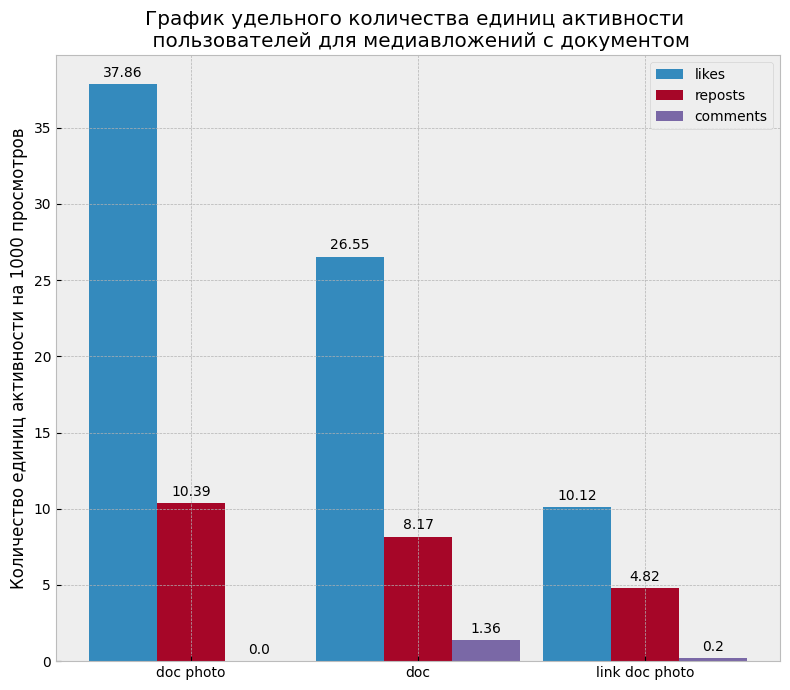

In [54]:
# Обозначаем список подписей
labels = data_att_doc.index

# Координата каждой подписи
x = np.arange(len(labels))  

# Ширина столбцов графика
width = 0.3


fig, ax = plt.subplots(figsize=(8,7))
rects1 = ax.bar(x - width/1, data_att_doc.likes.round(6), width, label='likes')
rects2 = ax.bar(x, data_att_doc.reposts.round(6), width, label='reposts')
rects3 = ax.bar(x + width/1, data_att_doc.comments.round(6), width, label='comments')

ax.set_ylabel('Тип медиавложений')
ax.set_ylabel('Количество единиц активности на 1000 просмотров')
ax.set_title('График удельного количества единиц активности \n пользователей для медиавложений с документом')
ax.set_xticks(x)
ax.set_xticklabels(labels)
ax.legend()

# Функция расстановки подписей для каждого столбца

def autolabel(rects):
    for rect in rects:
        height = rect.get_height()
        ax.annotate('{}'.format(height),
                    xy=(rect.get_x() + rect.get_width() / 2, height),
                    xytext=(0, 3),  # 3 points vertical offset
                    textcoords="offset points",
                    ha='center', va='bottom')

# Выполняем функцию для каждой метрики
        
autolabel(rects1)
autolabel(rects2)
autolabel(rects3)

fig.tight_layout()

plt.show()